In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8'
from deepsramp import *

## Data Preprocess

### Proprocess GTF and FASTA

In [2]:
%%time
gtf = read_gtf('data/Homo_sapiens.GRCh38.79.gtf.gz')
seqs = read_seq('data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:28: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
51662809it [02:04, 413467.83it/s]

CPU times: user 1min 38s, sys: 1min 5s, total: 2min 43s
Wall time: 2min 40s


In [3]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 14.5 s, sys: 740 ms, total: 15.3 s
Wall time: 15.3 s


In [4]:
%%time
gtfm = read_gtf('data/Mus_musculus.GRCm39.109.gtf.gz')
seqsm = read_seq('data/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:28: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
45470460it [01:51, 408561.56it/s]

CPU times: user 1min 21s, sys: 38.8 s, total: 2min
Wall time: 2min 17s


In [5]:
%%time
sdfm = get_mature_splice(gtfm, seqsm, grp=['id', 'trans'], keepmax=False)
ndfm = get_mature_cds(gtfm, sdfm, grp=['id', 'trans'])

CPU times: user 11.8 s, sys: 535 ms, total: 12.4 s
Wall time: 12.4 s


#### Full Trans Mode

In [10]:
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_full_splice(gtf, sdf, seqs, grp=['id', 'trans'])
ndf = get_full_cds(gtf, ndf, grp=['id', 'trans'])

In [11]:
sdfm = get_mature_splice(gtfm, seqsm, grp=['id', 'trans'], keepmax=False)
ndfm = get_full_splice(gtfm, sdfm, seqsm, grp=['id', 'trans'])
ndfm = get_full_cds(gtfm, ndfm, grp=['id', 'trans'])

### Preprocess of SRAMP1 data

In [14]:
def get_sramp_dataset_all(file, rndf, downsample=False, mode='mature'):
    train = pd.read_csv(file)
    train['Class'] = (train['Class'] + 1) // 2
    train['Position'] -= 1
    keep = []
    for _, trans, pos, claz in tqdm(train.itertuples(), total=train.shape[0]):
        if trans not in rndf.index: 
            keep += [0]
            continue
        if DRACH_PAT.findall(rndf.loc[trans].seq[pos-2:pos+3]):
            keep += [1]
        else:
            keep += [0]

    train['keep'] = keep

    train = train[train.keep == 1]
    if downsample:
        pos = train[train.Class == 1]
        neg = train[train.Class == 0].sample(pos.shape[0])
        train = pd.concat([pos, neg], axis=0)

    lookupdf = rndf.reset_index().set_index('id')
    res = []
    for idx, trans, pos, claz, _ in tqdm(train.itertuples(), total=train.shape[0]):
        tdf = rndf.loc[trans]
        genome_pos = get_genome_pos(pos, tdf, mode=mode)
        tdf = lookupdf.loc[[tdf.id]].copy()
        tres = []
        for _, ttdf in tdf.iterrows() :
            if mode == 'mature':
                trans_pos = get_mature_pos(genome_pos, ttdf)
            else:
                trans_pos = get_full_pos(genome_pos, ttdf)
            tres += [trans_pos]
        tdf['pos'] = tres
        tdf = tdf[tdf.pos != -1]
        tdf['label'] = claz
        tdf['grp'] = tdf[0] + tdf[6] + str(genome_pos)
        # tdf['grp'] = file + str(idx)
        res += [tdf.dropna()]
    res = pd.concat(res, axis=0)

    return res

In [7]:
rndf = ndf.reset_index().set_index('trans')
traindf = get_sramp_dataset_all('data/sramp1/mature_train.csv', rndf, downsample=True)
testdf = get_sramp_dataset_all('data/sramp1/mature_test.csv', rndf)

100%|██████████| 73551/73551 [02:57<00:00, 414.70it/s]


In [8]:
rndfm = ndfm.reset_index().set_index('trans')
traindfm = get_sramp_dataset_all('data/sramp1/mature_train.csv', rndfm, downsample=True)
testdfm = get_sramp_dataset_all('data/sramp1/mature_test.csv', rndfm)

100%|██████████| 45690/45690 [01:45<00:00, 432.76it/s]


In [9]:
utils.save([traindf, testdf], 'data/sramp1/sramp1_mature.data')

In [15]:
rndf = ndf.reset_index().set_index('trans')
traindf = get_sramp_dataset_all('data/sramp1/full_train.csv', rndf, downsample=True, mode='full')
testdf = get_sramp_dataset_all('data/sramp1/full_test.csv', rndf, mode='full')

100%|██████████| 83343/83343 [03:19<00:00, 417.01it/s]


In [16]:
rndfm = ndfm.reset_index().set_index('trans')
traindfm = get_sramp_dataset_all('data/sramp1/full_train.csv', rndfm, downsample=True, mode='full')
testdfm = get_sramp_dataset_all('data/sramp1/full_test.csv', rndfm, mode='full')

100%|██████████| 49395/49395 [01:53<00:00, 434.70it/s]


In [17]:
utils.save([traindf, testdf], 'data/sramp1/sramp1_full.data')

## Train

In [3]:
traindf, testdf = utils.load('data/sramp1/sramp1_mature.data')

In [ ]:
traindf, testdf = utils.load('data/sramp1/sramp1_full.data')

In [4]:
trainds = df2ds_multi(traindf)
traindl = ds2dl(trainds, batch_size=128, drop_last=True, num_workers=4)

testds = df2ds_multi(testdf)
testdl = ds2dl(testds, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 194716/194716 [02:09<00:00, 1508.07it/s]


In [ ]:
import time

# print(f'Building model')
device = "cuda" if torch.cuda.is_available() else "cpu"

test_res = []
for i in ['genomeonly', 'seqonly', 'full']:
    utils.setup_seed(42)
    model = MultiSRAMP(mode=i).to(device)
    loss_fn = TriLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)

    print(f'Start to train')
    start = time.time()
    train(model, loss_fn, optimizer, scheduler, traindl, testdl, epochs=31, device=device)
    end = time.time()
    test_res += [test_loop(testdl, model, device, loss_fn)]
    print(end-start)
    
    torch.save(model, f'model/{i}_400_mature.model')
    utils.save(test_res, f'model/{i}_400_mature.metrics')

## Time

In [ ]:
import time

# print(f'Building model')
device = "cuda" if torch.cuda.is_available() else "cpu"

test_res = []
for i in range(100, 701, 100):
    utils.setup_seed(42)
    model = MultiSRAMP(halfseqlen=i).to(device)
    loss_fn = TriLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)

    print(f'Start to train')
    start = time.time()
    train(model, loss_fn, optimizer, scheduler, traindl, testdl, epochs=31, device=device)
    end = time.time()
    test_res += [test_loop(testdl, model, device, loss_fn)]
    test_res += [end-start]
    print(end-start)
    
    torch.save(model, f'model/full_{i}_mature_for_time.model')
    utils.save(test_res, f'model/full_{i}_mature_for_time.metrics')

Start to train
[Epoch 01] loss: 0.697706  [     0/ 50884] 
[Epoch 02] loss: 0.397413  [     0/ 50884] 
[Epoch 03] loss: 0.325380  [     0/ 50884] 
[Epoch 04] loss: 0.317262  [     0/ 50884] 
[Epoch 05] loss: 0.325515  [     0/ 50884] 
[Epoch 06] loss: 0.263835  [     0/ 50884] 
[Epoch 07] loss: 0.331850  [     0/ 50884] 
[Epoch 08] loss: 0.281225  [     0/ 50884] 
[Epoch 09] loss: 0.318910  [     0/ 50884] 
[Epoch 10] loss: 0.328378  [     0/ 50884] 
[Epoch 11] loss: 0.334452  [     0/ 50884] 
[Epoch 12] loss: 0.239673  [     0/ 50884] 
[Epoch 13] loss: 0.315308  [     0/ 50884] 
[Epoch 14] loss: 0.305838  [     0/ 50884] 
[Epoch 15] loss: 0.305151  [     0/ 50884] 
[Epoch 16] loss: 0.298173  [     0/ 50884] 
[Epoch 17] loss: 0.250777  [     0/ 50884] 
[Epoch 18] loss: 0.334884  [     0/ 50884] 
[Epoch 19] loss: 0.255954  [     0/ 50884] 
[Epoch 20] loss: 0.219362  [     0/ 50884] 
[Epoch 21] loss: 0.331875  [     0/ 50884] 
[Epoch 22] loss: 0.290480  [     0/ 50884] 
[Epoch 23] loss: 

## Performance

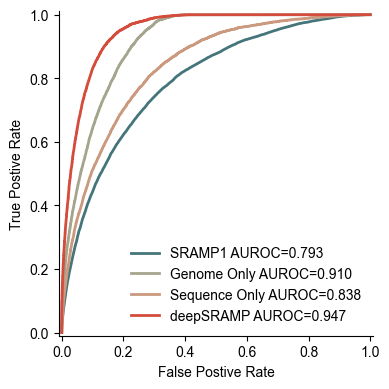

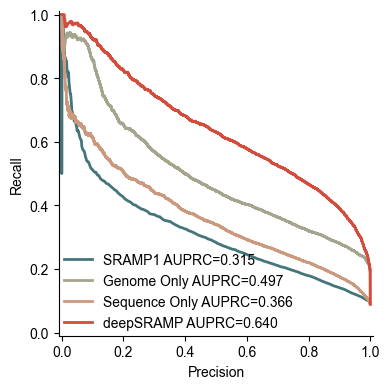

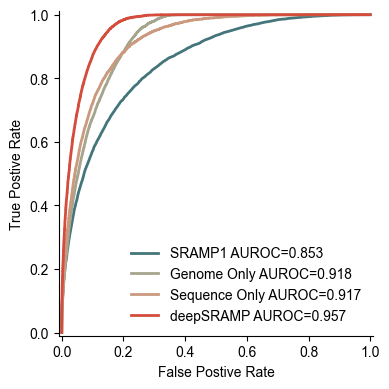

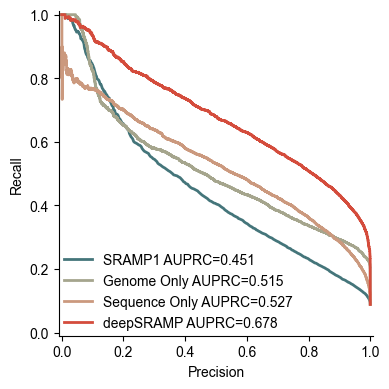

In [23]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

names = ['Genome Only', 'Sequence Only', 'deepSRAMP']


for mode in ['mature', 'full']:
    test_res = []
    for i in ['genomeonly', 'seqonly', 'full']:
        test_res += utils.load(f'model/{i}_400_{mode}.metrics')
    
    data = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])
    t = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'], index=[i for i in ['genomeonly', 'seqonly', 'full']])
    t.index.name = f'deepSRAMP[{mode}]'
    t.to_csv(f'fig/fig1b_{mode}.csv')

    # sramp1
    if mode == 'mature':
        a = pd.read_csv(f'sramp1_sramp1test.out', sep='\t')
    else:
        a = pd.read_csv(f'sramp1_sramp1test_full.out', sep='\t')
    a = a[a.Position == 51]
    a['y'] = a['Seq_ID'].astype(str).str.split('.', expand=True)[1].astype(int)
    ratio = a.y.sum() / a.shape[0]
    
    # auc
    fig = plt.figure(figsize=(4, 4))
    ax = fig.subplots()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    tpr, fpr, ths = roc_curve(a.y, a['Score(Combined)'])
    t1 = auc(tpr, fpr)
    plt.plot(tpr, fpr, label=f'SRAMP1 AUROC={t1:.3f}', lw=2, color='#44757A')
    
    colors = ['#A5A58D', '#CB997E', '#D44C3C']
    # colors = ['tab:orange', 'tab:purple', 'tab:red']
    for idx, (name, r) in enumerate(zip(names, test_res)):
        test_loss, aucc, auprcc, fpr, tpr, throc, reca, prec, thprc, mcc, report = r
        plt.plot(fpr, tpr, label=f'{name} AUROC={aucc:.3f}', lw=2, color=colors[idx])
    plt.legend(frameon=False)
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Postive Rate')
    plt.tight_layout()
    plt.savefig(f'fig/fig1b_roc_{mode}.svg', transparent=True)
    plt.show()
    
    # prc
    fig = plt.figure(figsize=(4, 4))
    ax = fig.subplots()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    tpr, fpr, ths = precision_recall_curve(a.y, a['Score(Combined)'])
    t2 = auc(fpr, tpr)
    # plt.plot(fpr, tpr, label=f'SRAMP1 AUC={t2:.3f}', lw=2)
    plt.plot(fpr, tpr, label=f'SRAMP1 AUPRC={t2:.3f}', lw=2, color='#44757A')
    
    
    for idx, (name, r) in enumerate(zip(names, test_res)):
        test_loss, aucc, auprcc, fpr, tpr, throc, reca, prec, thprc, mcc, report = r
        plt.plot(prec, reca, label=f'{name} AUPRC={auprcc:.3f}', lw=2, color=colors[idx])
    plt.legend(loc=(0,0), frameon=False)
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.tight_layout()
    plt.savefig(f'fig/fig1b_prc_{mode}.svg', transparent=True)
    plt.show()
    # break
    

## Predict

In [2]:
%%time
gtf = read_gtf('data/Homo_sapiens.GRCh38.79.gtf.gz')
seqs = read_seq('data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:30: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
51662809it [02:16, 379341.27it/s]

CPU times: user 1min 35s, sys: 1min 15s, total: 2min 50s
Wall time: 2min 51s


In [3]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False, biotype=None)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 27.3 s, sys: 1.15 s, total: 28.4 s
Wall time: 28.4 s


In [4]:
traindf, testdf = utils.load('data/sramp1/sramp1_mature.data')

In [5]:
m6anet = pd.read_csv('../tombo/m6anet.csv')
m6anet['trans'] = m6anet['transcript_id'].apply(lambda x: x.split('.')[0])
m6anet

,transcript_id,transcript_position,probability_modified,trans
0,ENST00000000233.9,244,0.055882,ENST00000000233
1,ENST00000000233.9,261,0.223134,ENST00000000233
2,ENST00000000233.9,316,0.009486,ENST00000000233
3,ENST00000000233.9,332,0.312288,ENST00000000233
4,ENST00000000233.9,368,0.109992,ENST00000000233
...,...,...,...,...
490823,ENST00000642050.1,2460,0.004574,ENST00000642050
490824,ENST00000642050.1,2465,0.058910,ENST00000642050
490825,ENST00000642050.1,2530,0.381975,ENST00000642050
490826,ENST00000642050.1,2549,0.338500,ENST00000642050


In [34]:
def get_m6a_pat(sdf, pat=DRACH_PAT):
    sdf['m6a_pat'] = sdf.apply(lambda x: get_drach(x.seq, pat), axis=1)
    return sdf

myndf = ndf.copy()
myndf = get_m6a_pat(myndf)
myndf = myndf.reset_index().explode('m6a_pat').merge(m6anet, left_on=['trans', 'm6a_pat'], right_on=['trans', 'transcript_position'])

In [37]:
mypos = (lambda x: set(x[x.label==1].grp))(traindf)

evaldf = []
for _, i in tqdm(myndf.iterrows(), total=myndf.shape[0]):
    trans = i['trans']
    gene = i['id']
    pos = i['m6a_pat']
    genome_pos = get_genome_pos(pos, i)
    grp = i[0]+i[6]+str(genome_pos)
    evaldf += [[pos, grp, 1 if grp in mypos else  0]] 

myndf = pd.concat([myndf, pd.DataFrame(evaldf, columns=['pos', 'grp', 'label'])], axis=1)
# myndf = myndf.merge(ndf, left_on=['id', 'trans'], right_index=True)

100%|██████████| 461333/461333 [00:28<00:00, 16320.41it/s]


In [38]:
evalds = df2ds_multi(myndf, agg=False)
evaldl = ds2dl(evalds, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 461333/461333 [04:24<00:00, 1741.15it/s]


In [39]:
def eval_loop(dataloader, model, device, loss_fn):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    preds = []
    ys = []
    
    with torch.no_grad():
        for X, y in tqdm(dataloader, total=num_batches):
            X = [x.to(device) for x in X]
            y = y.to(device)

            model.eval()
            pred = model.sramp(*X)
            test_loss += loss_fn(pred, y).item()
            
            preds += (nn.functional.sigmoid(pred[:, -1]).tolist())
            ys += (y[:, -1].tolist())
    return preds
            

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
utils.setup_seed(42)

model = MultiSRAMP().to(device)
# model.load_state_dict(torch.load('model/full_400_a549.model'))
model.load_state_dict(torch.load('model/full_400_mature.model'))
loss_fn = TriLoss()
preds = eval_loop(evaldl, model, device, loss_fn)


/tmp/ipykernel_2975375/2601017941.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/full_400_mature.model'))
100%|██████████| 3605/

In [59]:
myndf['pred'] = preds
myndf['plabel'] = myndf.pred > 0.85

In [42]:
from scipy.stats import spearmanr, ranksums
import matplotlib.pyplot as plt

In [43]:
spearmanr(myndf['probability_modified'], myndf['pred'])

SignificanceResult(statistic=np.float64(0.242681829036258), pvalue=np.float64(0.0))

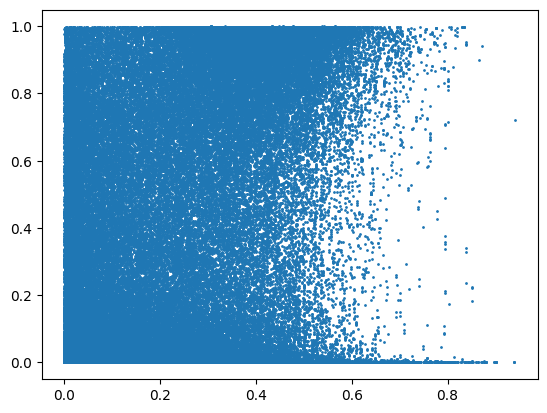

In [44]:
plt.scatter(myndf['probability_modified'], myndf['pred'], s=1)
# plt.yscale('log')

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [60]:
from scipy.stats import spearmanr, ranksums

for i in ['ENST00000291295', 'ENST00000391918', 'ENST00000486500']:
    s, p = ranksums(myndf[(myndf.trans == i) & (myndf.plabel == True)]['probability_modified'], 
                    myndf[(myndf.trans == i) & (myndf.plabel == False)]['probability_modified'])
    print(i, p)

ENST00000291295 0.017696229285467116
ENST00000391918 0.12663045794761718
ENST00000486500 0.004866020063943335


In [70]:
myndf[(myndf.trans == 'ENST00000391918') & (myndf.plabel == True)]

,id,trans,cds,0,6,range,length,splice,min,max,seq,m6a_pat,transcript_id,transcript_position,probability_modified,pos,grp,label,pred,plabel
315091,ENSG00000160014,ENST00000391918,"{208, 547}",19,+,"[(46601073, 46601176), (46605826, 46605857), (...",702,"{0, 385, 134, 103, 521, 278, 702}",46601073,46609305,GCGGCGAGGGAAAGTAGTCCGGCGACGGGAGCGAGCGCGCGCGCGC...,664,ENST00000391918.6,664,0.41838,664,19+46609267,1,0.998702,True


In [93]:
myndf['pplabel'] = myndf['plabel'].apply(lambda x: 'Positive' if x else 'Negative')

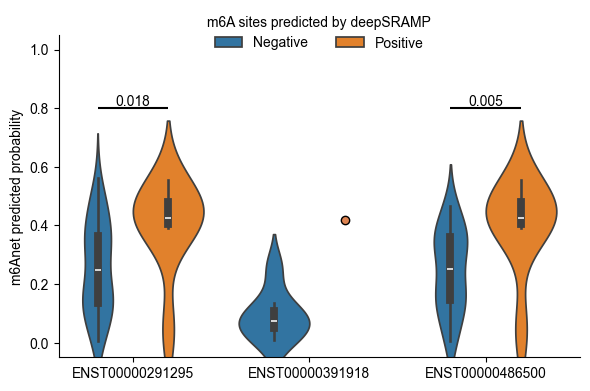

In [104]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

sns.violinplot(data=myndf[(myndf.trans.isin(['ENST00000291295', 'ENST00000391918', 'ENST00000486500'])) & (myndf.pos != 664)], 
               x='trans', y='probability_modified', hue='pplabel', bw_adjust=1, )
plt.scatter(1.2, 0.41838, color='#dd8452', edgecolors='black', linewidths=1)

plt.hlines(0.8, -0.2, 0.2, color='black')
plt.text(0, 0.8, '0.018', color='black', horizontalalignment='center', verticalalignment='bottom')

plt.hlines(0.8, 1.8, 2.2, color='black')
plt.text(2, 0.8, '0.005', color='black', horizontalalignment='center', verticalalignment='bottom')

plt.ylim(-0.05, 1.05)
plt.xlabel('')
plt.ylabel('m6Anet predicted probability')
plt.legend(title='m6A sites predicted by deepSRAMP', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.1), loc='upper center')
plt.tight_layout()
plt.savefig('fig/rfig4b.svg')
plt.show()


In [48]:
m = myndf[myndf.trans.isin(['ENST00000486500', 'ENST00000391918', 'ENST00000291295'])].groupby('trans').agg({
    'pos': list, 
    'pred': list,
    'grp': list,
    'min': lambda x: list(x)[0],
    'max': lambda x: list(x)[0],
    'range': lambda x: list(x)[0]
})
m

,pos,pred,grp,min,max,range
trans,,,,,,
ENST00000291295,"[1664, 385, 131, 260, 392, 533, 2197, 409, 105...","[4.4366581278154626e-05, 3.523076657074853e-06...","[19+46610168, 19+46608489, 19+46601366, 19+466...",46601235,46610793,"[(46601235, 46601437), (46605826, 46605857), (..."
ENST00000391918,"[650, 664, 538, 434, 451, 335, 488, 380]","[0.5006062388420105, 0.9987021684646606, 0.415...","[19+46609253, 19+46609267, 19+46609141, 19+466...",46601073,46609305,"[(46601073, 46601176), (46605826, 46605857), (..."
ENST00000486500,"[896, 387, 262, 1923, 394, 792, 2456, 411, 130...","[0.11187920719385147, 2.9918121526861796e-06, ...","[19+46609141, 19+46608489, 19+46608223, 19+466...",46607961,46610781,"[(46607961, 46608340), (46608481, 46608981), (..."


In [49]:
t = myndf[myndf.trans.isin(['ENST00000486500', 'ENST00000391918', 'ENST00000291295'])]
t['plabel'] = t.pred > 0.85
t[t.plabel == 1]#.grp.value_counts()
# .groupby('grp').agg({''})

/tmp/ipykernel_2975375/1967950361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['plabel'] = t.pred > 0.85


,id,trans,cds,0,6,range,length,splice,min,max,seq,m6a_pat,transcript_id,transcript_position,probability_modified,pos,grp,label,pred,plabel
315057,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1567,ENST00000291295.13,1567,0.477355,1567,19+46610071,0,0.911375,True
315061,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1190,ENST00000291295.13,1190,0.487890,1190,19+46609694,1,0.984010,True
315071,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1221,ENST00000291295.13,1221,0.410897,1221,19+46609725,1,0.946401,True
315073,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1353,ENST00000291295.13,1353,0.430227,1353,19+46609857,0,0.953301,True
315082,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1382,ENST00000291295.13,1382,0.553791,1382,19+46609886,1,0.882928,True
315083,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,749,ENST00000291295.13,749,0.042459,749,19+46609253,0,0.901625,True
315086,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1270,ENST00000291295.13,1270,0.391123,1270,19+46609774,1,0.946805,True
315088,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,763,ENST00000291295.13,763,0.419054,763,19+46609267,1,0.997032,True
315091,ENSG00000160014,ENST00000391918,"{208, 547}",19,+,"[(46601073, 46601176), (46605826, 46605857), (...",702,"{0, 385, 134, 103, 521, 278, 702}",46601073,46609305,GCGGCGAGGGAAAGTAGTCCGGCGACGGGAGCGAGCGCGCGCGCGC...,664,ENST00000391918.6,664,0.418380,664,19+46609267,1,0.998702,True
315129,ENSG00000160014,ENST00000486500,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,"{0, 2536, 379, 879}",46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,1826,ENST00000486500.1,1826,0.477355,1826,19+46610071,0,0.892237,True


In [55]:
myndf[myndf.trans.isin(['ENST00000291295'])].sort_values('pos')

,id,trans,cds,0,6,range,length,splice,min,max,seq,m6a_pat,transcript_id,transcript_position,probability_modified,pos,grp,label,pred,plabel
315064,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,48,ENST00000291295.13,48,0.056397,48,19+46601283,0,1.545287e-06,False
315049,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,131,ENST00000291295.13,131,0.561833,131,19+46601366,0,1.435912e-06,False
315058,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,161,ENST00000291295.13,161,0.424020,161,19+46601396,0,7.134951e-07,False
315067,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,182,ENST00000291295.13,182,0.144370,182,19+46601417,0,1.600288e-06,False
315076,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,206,ENST00000291295.13,206,0.158168,206,19+46605830,0,4.251728e-07,False
315077,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,214,ENST00000291295.13,214,0.492362,214,19+46605838,0,2.067025e-06,False
315050,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,260,ENST00000291295.13,260,0.120857,260,19+46608223,0,1.301051e-06,False
315063,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,301,ENST00000291295.13,301,0.177782,301,19+46608264,0,3.048662e-06,False
315069,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,321,ENST00000291295.13,321,0.156258,321,19+46608284,0,3.018393e-06,False
315072,ENSG00000160014,ENST00000291295,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,326,ENST00000291295.13,326,0.252688,326,19+46608289,0,8.215254e-07,False


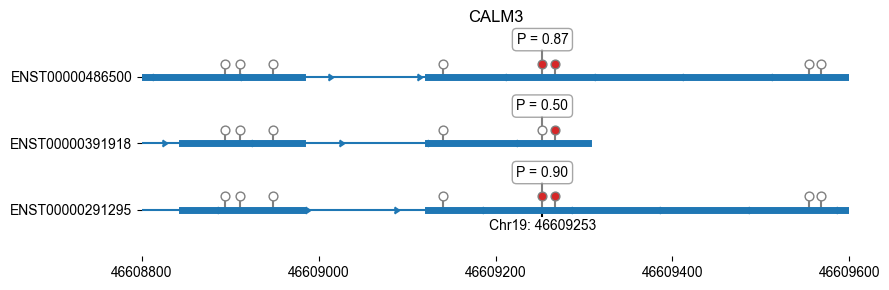

In [114]:
fig = plt.figure(figsize=(9, 3))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

lw = 5
for i, j in enumerate(m.index):
    trans = m.loc[j]
    plt.plot([trans['min'], trans['max']], [j, j], c='tab:blue')
    
    for k in trans.range:
        plt.plot(k, [j, j], color='tab:blue', lw=lw, zorder=2)
        
    for k in range(trans['min']+50, trans['max'], 100):
        plt.scatter(k, j, c='tab:blue', marker=9, s=20)

    hl = 0
    tzip = list(zip(trans.pos, trans.pred, trans.grp))
    tzip = sorted(tzip, key=lambda x: x[0])
    
    for k, p, g in tzip:
        g = g.split('+')[1] if '+' in g else g.split('-')[1]
        g = int(g)
        
        plt.plot([g, g], [i, i+.2], c='grey', zorder=1)
        if p > 0.85:
            plt.scatter([g], [i+.2], s=40, color='tab:red', edgecolors='grey', zorder=2)
            # if hl % 2 == 1:
            #     plt.plot([g, g], [i+.2, i+.3], c='grey', zorder=1)
            #     plt.text(g, i+.4, f'{p:.2f}', horizontalalignment='center', zorder=2, bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.7))
            # else:
            #     plt.plot([g, g], [i+.2, i+.6], c='grey', zorder=1)
            #     plt.text(g, i+.7, f'{p:.2f}', horizontalalignment='center', zorder=2, bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.7))
            # hl += 1
        else:
            plt.scatter([g], [i+.2], s=40, color='w', edgecolors='grey', zorder=2)

        if g == 46609253:
            plt.plot([g, g], [i+.2, i+.4], c='grey', zorder=1)
            plt.text(g, i+.5, f'P = {p:.2f}', horizontalalignment='center', zorder=2, bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.7))
            if j == 'ENST00000291295':
                plt.plot([g, g], [i, i-.1], c='black', zorder=1)
                plt.text(g, i-.3, f'Chr19: 46609253', horizontalalignment='center', zorder=2, bbox=dict(boxstyle='round', facecolor='white', edgecolor='w', alpha=0.0))
            

plt.xlim((46608800, 46609600))
plt.xticks(range(46608800, 46609601, 200))
plt.ticklabel_format(axis='x', style='plain', useOffset=False)
plt.title('CALM3')
plt.ylim((-.7, 2.7))

plt.tight_layout()
plt.savefig('fig/fig4b.svg')
plt.show()

<Axes: ylabel='probability_modified'>

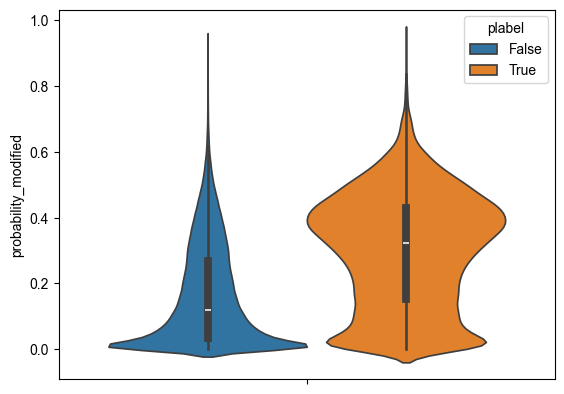

In [54]:
sns.violinplot(data=myndf, y='probability_modified', hue='plabel')

In [79]:
traindf, testdf = utils.load('data/sramp1/sramp1_mature.data')

In [82]:
def get_m6a_pat(sdf, pat=DRACH_PAT):
    sdf['m6a_pat'] = sdf.apply(lambda x: get_drach(x.seq, pat), axis=1)
    return sdf

gene = 'ENSG00000160014'
myndf = ndf.loc[gene]
myndf = get_m6a_pat(myndf)
mypos = (lambda x: set(x[x.label==1].grp))(traindf.loc[gene])

evaldf = []
for trans, i in tqdm(myndf.iterrows(), total=myndf.shape[0]):
    for pos in i['m6a_pat']:
        genome_pos = get_genome_pos(pos, i)
        grp = i[0]+i[6]+str(genome_pos)
        evaldf += [[gene, trans, pos, grp, 1 if grp in mypos else  0]] 

myndf = pd.DataFrame(evaldf, columns=['id', 'trans', 'pos', 'grp', 'label'])
myndf = myndf.merge(ndf, left_on=['id', 'trans'], right_index=True)

 36%|███▌      | 71346/198278 [00:39<00:53, 2386.45it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f48f1ec8710>>
Traceback (most recent call last):
  File "/home/fanrui/miniforge3/envs/sramp/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
 46%|████▌     | 90920/198278 [00:51<01:00, 1761.96it/s]

KeyboardInterrupt



In [11]:
evalds = df2ds_multi(myndf, agg=False)
evaldl = ds2dl(evalds, batch_size=128, shuffle=False)

100%|██████████| 303/303 [00:00<00:00, 4070.81it/s]


In [14]:
def eval_loop(dataloader, model, device, loss_fn):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    preds = []
    ys = []
    
    with torch.no_grad():
        for X, y in tqdm(dataloader, total=num_batches):
            X = [x.to(device) for x in X]
            y = y.to(device)

            model.eval()
            pred = model.sramp(*X)
            test_loss += loss_fn(pred, y).item()
            
            preds += (nn.functional.sigmoid(pred[:, -1]).tolist())
            ys += (y[:, -1].tolist())
    return preds
            

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
utils.setup_seed(42)

model = MultiSRAMP().to(device)
model.load_state_dict(torch.load('model/full_400_a549.model'))
loss_fn = TriLoss()
preds = eval_loop(evaldl, model, device, loss_fn)


/tmp/ipykernel_3550926/2137976291.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/full_400_a549.model'))
100%|██████████| 3/3 [00

In [16]:
len(preds)

303

In [78]:
myndf['pred'] = preds
myndf['plabel'] = myndf.pred > 0.5

In [73]:
m6anet = pd.read_csv('../tombo/m6anet.csv', header=None)
m6anet = m6anet.groupby([0, 1]).agg({3: 'max'}).reset_index()
m6anet['trans'] = m6anet[0].apply(lambda x: x.split('.')[0])
m6anet = m6anet.merge(myndf, left_on=['trans', 1], right_on=['trans', 'pos'])

In [28]:
m6anet

,0_x,1,3,trans,id,pos,grp,label,cds,0_y,6,range,length,splice,min,max,seq,pred,plabel
0,ENST00000291295.13,48,0.056397,ENST00000291295,ENSG00000160014,48,19+46601283,0,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1.412440e-06,False
1,ENST00000291295.13,131,0.561833,ENST00000291295,ENSG00000160014,131,19+46601366,0,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1.270294e-06,False
2,ENST00000291295.13,161,0.424020,ENST00000291295,ENSG00000160014,161,19+46601396,0,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1.290414e-06,False
3,ENST00000291295.13,182,0.144370,ENST00000291295,ENSG00000160014,182,19+46601417,0,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,1.838790e-06,False
4,ENST00000291295.13,206,0.158168,ENST00000291295,ENSG00000160014,206,19+46605830,0,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,2.060877e-06,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,ENST00000486500.1,2291,0.466177,ENST00000486500,ENSG00000160014,2291,19+46610536,0,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,"{0, 2536, 379, 879}",46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,9.052297e-07,False
83,ENST00000486500.1,2374,0.357365,ENST00000486500,ENSG00000160014,2374,19+46610619,0,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,"{0, 2536, 379, 879}",46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,1.952352e-06,False
84,ENST00000486500.1,2421,0.346053,ENST00000486500,ENSG00000160014,2421,19+46610666,0,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,"{0, 2536, 379, 879}",46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,1.744051e-06,False
85,ENST00000486500.1,2456,0.010577,ENST00000486500,ENSG00000160014,2456,19+46610701,0,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,"{0, 2536, 379, 879}",46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,1.710054e-06,False


In [47]:
from scipy.stats import spearmanr, ranksums
import matplotlib.pyplot as plt

In [60]:
a = m6anet[m6anet.trans == 'ENST00000391918']

In [61]:
spearmanr(a[3], a['pred'])

SignificanceResult(statistic=np.float64(0.19047619047619052), pvalue=np.float64(0.6514014957024814))

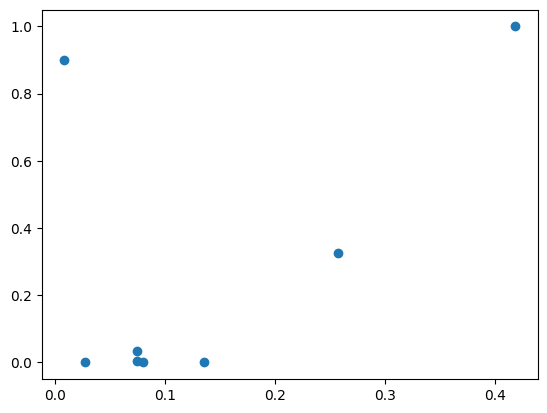

In [62]:
plt.scatter(a[3], a['pred'])
# plt.yscale('log')

In [51]:
m6anet.groupby(['trans', 'plabel']).agg({3: 'mean'})

3
trans           plabel          
ENST00000291295 False   0.244242
                True    0.379253
ENST00000391918 False   0.108388
                True    0.213468
ENST00000486500 False   0.242282
                True    0.370367

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='trans', ylabel='3'>

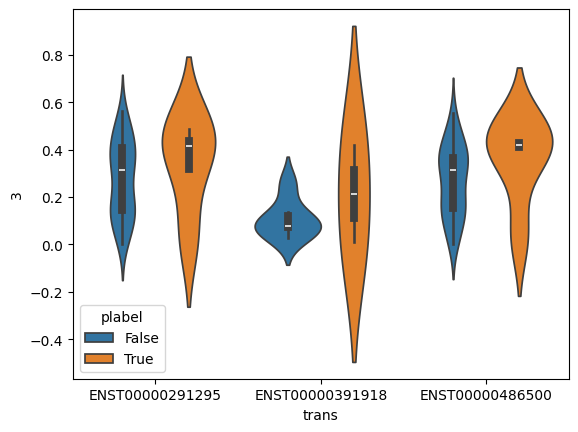

In [74]:
sns.violinplot(data=m6anet, x='trans', y=3, hue='plabel')

In [75]:
ranksums(m6anet[(m6anet.trans == 'ENST00000291295') & (m6anet.plabel == True)][3], 
         m6anet[(m6anet.trans == 'ENST00000291295') & (m6anet.plabel == False)][3])

RanksumsResult(statistic=np.float64(0.7944299095067362), pvalue=np.float64(0.42694519779809603))

In [76]:
ranksums(m6anet[(m6anet.trans == 'ENST00000391918') & (m6anet.plabel == True)][3], 
         m6anet[(m6anet.trans == 'ENST00000391918') & (m6anet.plabel == False)][3])

RanksumsResult(statistic=np.float64(0.0), pvalue=np.float64(1.0))

In [77]:
ranksums(m6anet[(m6anet.trans == 'ENST00000486500') & (m6anet.plabel == True)][3], 
         m6anet[(m6anet.trans == 'ENST00000486500') & (m6anet.plabel == False)][3])

RanksumsResult(statistic=np.float64(1.5323879172252337), pvalue=np.float64(0.12542673732266885))

In [164]:
myndf.to_csv('ENSG00000160014.csv')

In [314]:
bed = pd.read_csv('../tombo/ENST00000291295.bed', sep='\t', header=None)
bed['trans'] = bed[0].str.split('.', expand=True)[0]

In [315]:
bed = myndf[myndf.trans.isin(['ENST00000291295', ''])].merge(bed, left_on=['trans', 'pos'], right_on=['trans', 1]) #ENST00000486500

In [318]:
print('ENST00000291295', 0.5, 'median')
bed.groupby('plabel').agg({2: 'median'})

ENST00000291295 0.5 median


,2
plabel,
False,0.5211
True,0.6018


In [298]:
bed.to_csv('ENSG00000160014.csv')

In [304]:
bed[bed.plabel]

,id,trans,pos,grp,label,cds,0_x,6,range,length,...,min,max,seq,pred,plabel,0_y,1,2,3,4
14,ENSG00000160014,ENST00000291295,1190,19+46609694,1,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,...,46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,0.935572,True,ENST00000291295.13,1190,0.8268,155,ENST00000291295.13|1190
24,ENSG00000160014,ENST00000291295,1221,19+46609725,1,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,...,46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,0.960674,True,ENST00000291295.13,1221,0.4471,156,ENST00000291295.13|1221
36,ENSG00000160014,ENST00000291295,749,19+46609253,0,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,...,46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,0.957144,True,ENST00000291295.13,749,0.2045,151,ENST00000291295.13|749
41,ENSG00000160014,ENST00000291295,763,19+46609267,1,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,...,46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,0.999154,True,ENST00000291295.13,763,0.5093,151,ENST00000291295.13|763
50,ENSG00000160014,ENST00000486500,1449,19+46609694,1,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,...,46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,0.957170,True,ENST00000486500.1,1449,0.9600,28,ENST00000486500.1|1449
54,ENSG00000160014,ENST00000486500,1480,19+46609725,1,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,...,46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,0.971733,True,ENST00000486500.1,1480,0.4091,31,ENST00000486500.1|1480
55,ENSG00000160014,ENST00000486500,1612,19+46609857,0,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,...,46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,0.897398,True,ENST00000486500.1,1612,0.5161,37,ENST00000486500.1|1612
62,ENSG00000160014,ENST00000486500,1008,19+46609253,0,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,...,46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,0.930510,True,ENST00000486500.1,1008,0.3750,10,ENST00000486500.1|1008
67,ENSG00000160014,ENST00000486500,1022,19+46609267,1,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,...,46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,0.994068,True,ENST00000486500.1,1022,0.2222,11,ENST00000486500.1|1022


In [194]:
for _, i in myndf[myndf.grp == '19+46609253'].iterrows():
    trans, pos = i['trans'], i['pos']
    res = !cat ../tombo/wt_rrach.dampened_fraction_modified_reads.plus.wig | grep $trans -A $pos
    print(res != [], trans, end=' ')
    for j in res[1:]:
        if j.startswith('variable'):
            break
        if j.startswith(str(pos+1)):
            print(j, end=' ')
            break
    print()


True ENST00000291295 750 0.1909 
False ENST00000391918 
True ENST00000477244 
True ENST00000486500 1009 0.2727 
True ENST00000596362 687 0.2222 
False ENST00000597743 
False ENST00000597868 
True ENST00000599839 613 0.0000 


In [217]:
wigs = []
preds = []
for trans, i in myndf[myndf.trans.isin(['ENST00000291295', 'ENST00000486500'])].groupby('trans'):
    length = i['length'].iloc[0].item()
    res = !cat ../tombo/wt_rrach.dampened_fraction_modified_reads.plus.wig | grep $trans -A $length
    print(res != [], trans)
    for _, k in i.iterrows():
        pos = k['pos']
        for j in res[1:]:
            if j.startswith('variable'):
                break
            if j.startswith(str(pos+1)):
                print(j)
                wigs += [float(j.split(' ')[1])]
                preds += [k['pred']]
                break


True ENST00000291295
1665 0.2727
386 0.3302
132 0.2688
261 0.9490
393 0.2857
534 0.4400
2198 0.1274
410 0.2478
1051 0.5412
1437 0.0820
1568 0.5857
162 0.8537
1316 0.3772
551 0.3717
1191 0.8779
1065 0.6559
302 0.8488
49 0.5833
1586 0.3235
435 0.5934
183 0.3421
441 0.5875
322 0.5957
2116 0.5537
1222 0.3765
327 0.2135
1354 0.4478
588 0.5100
1870 0.2333
207 0.3765
215 0.8718
1753 0.2576
1885 0.7972
2270 0.9041
480 0.8667
1383 0.9527
750 0.1909
2033 0.4132
2163 0.3884
1271 0.9014
1275 0.4434
764 0.6514
638 0.3443
True ENST00000486500
897 0.0000
1330 0.2857
1924 0.2727
793 0.2000
2457 0.2250
1310 0.5882
1696 0.0667
1827 0.5294
1575 0.3571
810 0.2000
1450 0.8966
1324 0.5294
1845 0.4483
1980 0.7368
2375 0.5641
1481 0.3636
1613 0.3939
2060 0.0189
847 0.6667
2129 0.2571
2130 0.1190
2012 0.2439
2144 0.7500
2529 0.8235
1010 0.2000
1642 0.9189
1009 0.2727
2292 0.4706
2422 0.4865
1530 0.8667
1534 0.5600
1023 0.3846


In [213]:
from scipy.stats import spearmanr 

In [292]:
spearmanr(bed[2], bed['pred'])

SignificanceResult(statistic=np.float64(-0.0005535037743483551), pvalue=np.float64(0.9964257394743923))

In [272]:
import matplotlib.pyplot as plt

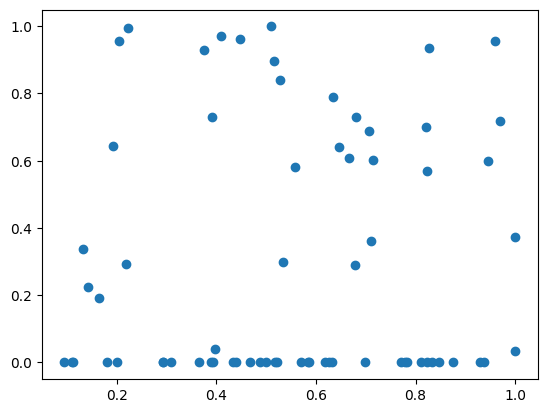

In [293]:
plt.scatter(bed[2], bed['pred'])
# plt.yscale('log')

In [189]:
myndf[myndf.grp == '19+46609253']

,id,trans,pos,grp,label,cds,0,6,range,length,splice,min,max,seq,pred,plabel
36,ENSG00000160014,ENST00000291295,749,19+46609253,0,"{646, 199}",19,+,"[(46601235, 46601437), (46605826, 46605857), (...",2289,"{0, 484, 233, 202, 620, 2289, 377}",46601235,46610793,GTGGGGCGGGGCCGAGCGAGGCGGGGCGCGCGCGGCGGCCGTTGAG...,0.901625,True
43,ENSG00000160014,ENST00000391918,650,19+46609253,0,"{208, 547}",19,+,"[(46601073, 46601176), (46605826, 46605857), (...",702,"{0, 385, 134, 103, 521, 278, 702}",46601073,46609305,GCGGCGAGGGAAAGTAGTCCGGCGACGGGAGCGAGCGCGCGCGCGC...,0.500606,True
66,ENSG00000160014,ENST00000477244,674,19+46609253,0,"{0, -1}",19,+,"[(46601308, 46601437), (46605826, 46605857), (...",696,"{0, 129, 160, 545, 302, 696, 409}",46601308,46609275,GCGGCGGCGCGCGCTGCGGGCAGTGAGTGTGGAGGCGCGGACGCGC...,0.243118,False
142,ENSG00000160014,ENST00000486500,1008,19+46609253,0,"{0, -1}",19,+,"[(46607961, 46608340), (46608481, 46608981), (...",2536,"{0, 2536, 379, 879}",46607961,46610781,AATAGCTTCACCTAGCACAGTGTTGATGTTCAATAACTGTTGAATG...,0.866224,True
193,ENSG00000160014,ENST00000596362,686,19+46609253,0,"{136, 583}",19,+,"[(46602071, 46602210), (46605826, 46605857), (...",1203,"{0, 421, 170, 139, 557, 1203, 314}",46602071,46609770,ACTGCAGAGGAGGAGGAGGGTGAGGTGCAAGCTTATGGGAGGAAGA...,0.892767,True
221,ENSG00000160014,ENST00000597743,511,19+46609253,0,"{408, 159}",19,+,"[(46601275, 46601437), (46605826, 46605857), (...",577,"{0, 193, 162, 577, 324, 382}",46601275,46609319,GTTGAGGGACCGTTGGGGCGGGAGGCGGCGGCGGCGGCGGCGCGCG...,0.561851,True
242,ENSG00000160014,ENST00000597868,875,19+46609253,0,"{0, -1}",19,+,"[(46601366, 46601437), (46605826, 46605857), (...",927,"{0, 102, 71, 746, 246, 927}",46601366,46609305,ACTGCTGCAGCTGCTGCCGCCGCCGGAGGAACCTTGATCCCCGTGC...,0.468484,False
284,ENSG00000160014,ENST00000599839,612,19+46609253,0,"{170, 509}",19,+,"[(46602068, 46602090), (46602596, 46602639), (...",1355,"{0, 65, 96, 483, 1355, 240, 22, 347}",46602068,46609996,AGCACTGCAGAGGAGGAGGAGGGAAGAACGCGGCTGGGTGGAAGAC...,0.900967,True


In [182]:
for i in (myndf[['trans', 'length']].drop_duplicates()).itertuples():
    print(i.trans)
    break

ENST00000291295


In [176]:
!cat ../tombo/wt_rrach.dampened_fraction_modified_reads.plus.wig | grep ENST00000291295 -A 2289

variableStep chrom=ENST00000291295.13 span=1
5 0.3333
6 0.5000
7 0.5000
8 0.6000
9 0.5000
10 0.6000
11 0.6667
12 0.6000
13 0.6667
14 0.6667
15 0.6667
16 0.7143
17 0.6667
18 0.7143
19 0.5714
20 0.7500
21 0.6667
22 0.7500
23 0.7143
24 0.6250
25 0.6667
26 0.5000
27 0.7000
28 0.6250
29 0.5000
30 0.6250
31 0.7500
32 0.6364
33 0.7500
34 0.8462
35 0.5714
36 0.5000
37 0.3750
38 0.4000
39 0.3333
40 0.4000
41 0.5000
42 0.5625
43 0.5455
44 0.2667
45 0.3529
46 0.3158
47 0.4000
48 0.5714
49 0.5833
50 0.5417
51 0.5200
52 0.6500
53 0.5926
54 0.5000
55 0.5769
56 0.5600
57 0.9032
58 0.9062
59 0.9444
60 0.7097
61 0.7353
62 0.7436
63 0.8000
64 0.8438
65 0.6944
66 0.6744
67 0.6591
68 0.7209
69 0.7200
70 0.6226
71 0.5714
72 0.6111
73 0.6379
74 0.6071
75 0.7193
76 0.6833
77 0.6863
78 0.5098
79 0.8148
80 0.7885
81 0.8772
82 0.4615
83 0.5102
84 0.5273
85 0.6071
86 0.5085
87 0.4286
88 0.5690
89 0.7547
90 0.8333
91 0.6271
92 0.4839
93 0.4310
94 0.5806
95 0.6774
96 0.7759
97 0.6667
98 0.5806
99 0.7647
100 0.9351